# MLClass. "Прикладной анализ данных"
# Модуль "Машинное обучение с помощью Python"
<img src="../img/mlclass_logo.jpg" height="240" width="240">
## Автор материала: Станислав Семенов
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

## Разбор решения задачи Kaggle Otto Group "Classify products into correct category" 

Подключаем библиотеки

In [1]:
%pylab inline

import numpy as np
import pandas as pd

import random
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfTransformer
from multiprocessing import Pool
import gc

import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


Считываем данные

In [3]:
dtrain = pd.read_csv('../data/otto_train.csv')
dtest = pd.read_csv('../data/otto_test.csv')

Записываем функцию метрики

In [4]:
def multiclass_log_loss(y_true, y_pred, eps = 1e-15):
    predictions = np.clip(y_pred, eps, 1 - eps)
    predictions /= predictions.sum(axis=1)[:, np.newaxis]

    actual = np.zeros(y_pred.shape)
    rows = actual.shape[0]
    actual[np.arange(rows), y_true.astype(int)] = 1
    vsota = np.sum(actual * np.log(predictions))
    
    return -1.0 / rows * vsota

Разбиваем на фолды

In [5]:
gibaindtrain1 = []
gibaindtrain2 = []

for giba in range(5):
    gibaindtrain1.append(arange(len(dtrain))[arange(len(dtrain)) % 5 != giba])
    gibaindtrain2.append(arange(len(dtrain))[arange(len(dtrain)) % 5 == giba])

Записываем в матрицу признаков, ответов

In [6]:
Xtrain = np.array(dtrain.ix[:, 1:-1])
Xtest = np.array(dtest.ix[:, 1:])

ytrain = []
for i in range(len(dtrain)):
    ytrain.append(int(dtrain['target'][i][-1]) - 1)
    
ytrain = np.array(ytrain).astype(int32)

Xall = np.vstack((Xtrain, Xtest))

Xtrain = Xall[:len(dtrain)]
Xtest = Xall[len(dtrain):]

print shape(Xtrain), shape(Xtest)

(61878, 93) (144368, 93)


Пробуем визуализировать данные

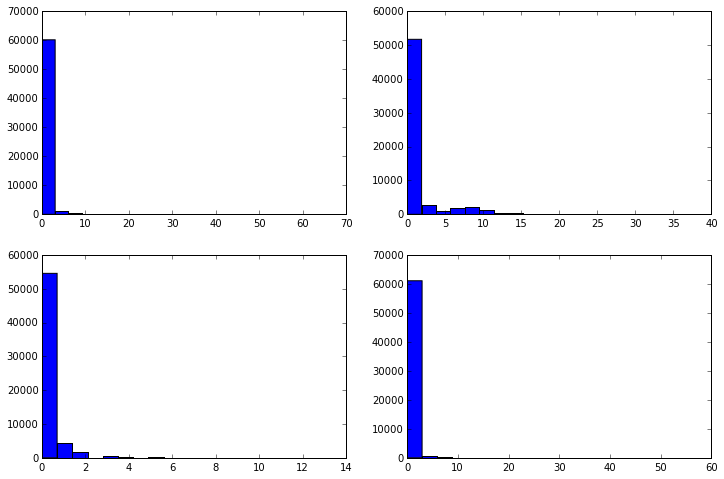

In [7]:
figsize(12, 8)

subplot(2, 2, 1)
h = hist(Xtrain[:, 0], bins = 20)

subplot(2, 2, 2)
h = hist(Xtrain[:, 10], bins = 20)

subplot(2, 2, 3)
h = hist(Xtrain[:, 20], bins = 20)

subplot(2, 2, 4)
h = hist(Xtrain[:, 30], bins = 20)

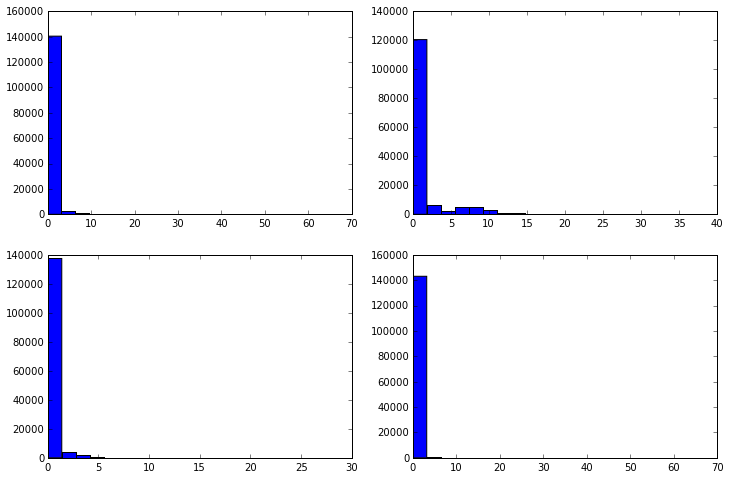

In [8]:
figsize(12, 8)

subplot(2, 2, 1)
h = hist(Xtest[:, 0], bins = 20)

subplot(2, 2, 2)
h = hist(Xtest[:, 10], bins = 20)

subplot(2, 2, 3)
h = hist(Xtest[:, 20], bins = 20)

subplot(2, 2, 4)
h = hist(Xtest[:, 30], bins = 20)

Попробуем применить лог-преобразование

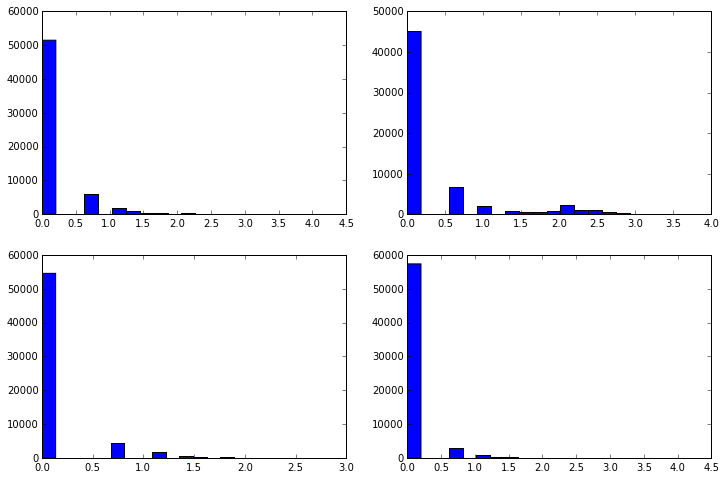

In [9]:
figsize(12, 8)

subplot(2, 2, 1)
h = hist(np.log(Xtrain[:, 0] + 1), bins = 20)

subplot(2, 2, 2)
h = hist(np.log(Xtrain[:, 10] + 1), bins = 20)

subplot(2, 2, 3)
h = hist(np.log(Xtrain[:, 20] + 1), bins = 20)

subplot(2, 2, 4)
h = hist(np.log(Xtrain[:, 30] + 1), bins = 20)

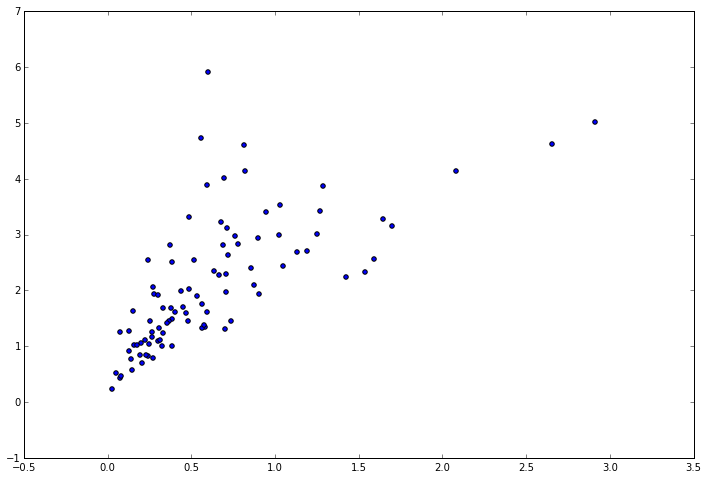

In [10]:
means = np.mean(Xall, axis = 0)
stds = np.std(Xall, axis = 0)

figsize(12, 8)

scatter(means, stds)

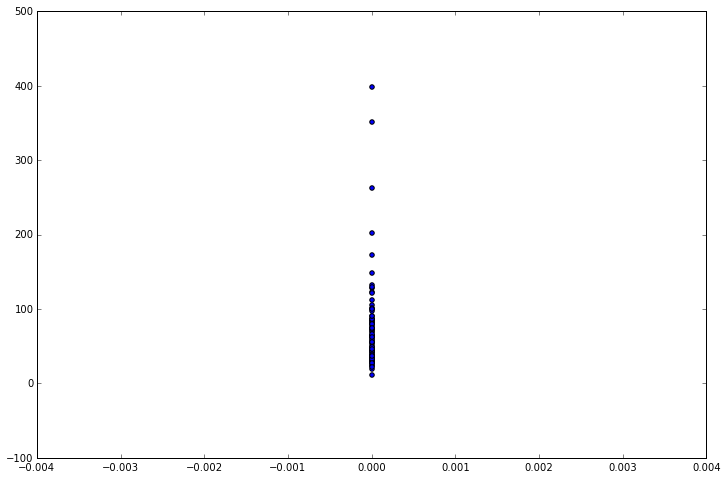

In [11]:
mins = np.min(Xall, axis = 0)
maxs = np.max(Xall, axis = 0)

figsize(12, 8)

scatter(mins, maxs)

Посмотрим на распределения y

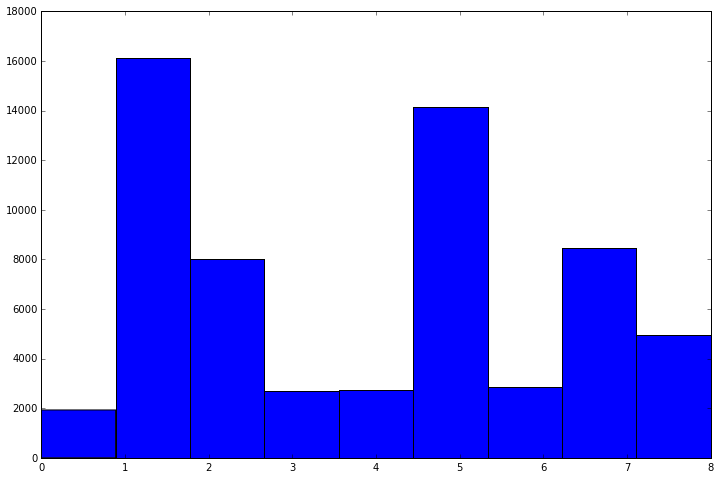

In [12]:
h = hist(ytrain, bins = 9)

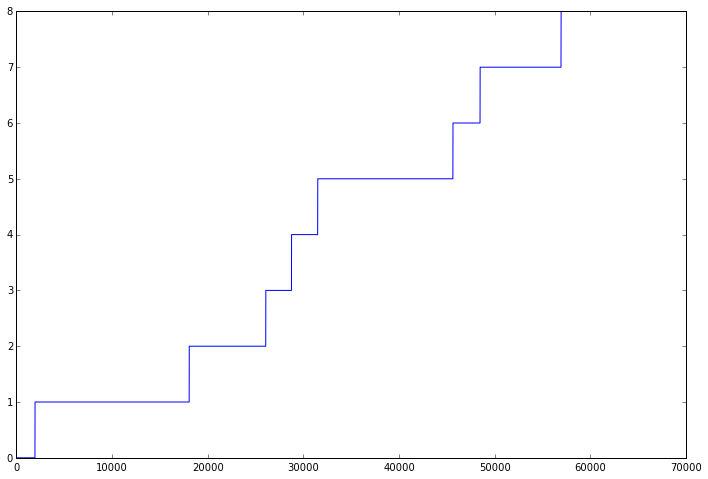

In [13]:
plot(arange(len(ytrain)), ytrain)

Настроим параметры бустинга

In [14]:
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'multi:softprob'
param['num_class'] = 9
param['eval_metric'] = 'logloss'
param['scale_pos_weight'] = 1.0
param['bst:eta'] = 0.3
param['bst:max_depth'] = 15
param['bst:colsample_bytree'] = 0.4
param['gamma'] = 0.5
param['min_child_weight'] = 5.
param['silent'] = 1
param['nthread'] = 30

num_round = 100

plst = list(param.items())

watchlist = []

Создадим функцию, которая бы обучала бустинговые деревья на одних индексах и предсказывала для других

In [27]:
def stasxg(indtrain1, indtrain2):    
    ypredxg = np.zeros((len(indtrain2), 9))

    bgs = 10
    for bg in range(bgs):
        param['seed'] = bg + 1
        plst = list(param.items())
        
        newindtrain = random.sample(indtrain1, int(len(indtrain1) * 1.0))

        for i in range(int(len(indtrain1) * 0.0)):
            newindtrain.append(random.choice(indtrain1))

        Xdatatrain = xgb.DMatrix(data = Xtrain[newindtrain], label = ytrain[newindtrain])
        Xdatatest = xgb.DMatrix(data = Xtrain[indtrain2])

        bst = xgb.train(plst, Xdatatrain, num_round, watchlist)

        curpred = bst.predict(Xdatatest).reshape((len(indtrain2), 9))        

        ypredxg += curpred

        print bg, multiclass_log_loss(ytrain[indtrain2], curpred), multiclass_log_loss(ytrain[indtrain2], ypredxg / (bg + 1))
        
    ypredxg /= bgs
    
    losses = []
    for i in range(9):
        losses.append(multiclass_log_loss(ytrain[indtrain2][ytrain[indtrain2] == i], ypredxg[ytrain[indtrain2] == i, :]) * sum(ytrain[indtrain2] == i) / len(indtrain2))
    
    return multiclass_log_loss(ytrain[indtrain2], ypredxg), losses, ypredxg


Обучим бустинговые деревья

In [28]:
t0 = time.time()

arres = []
arrlos = []
allypred = np.zeros((len(ytrain), 9))
for giba in range(5):
    indtrain1 = gibaindtrain1[giba]
    indtrain2 = gibaindtrain2[giba]

    curres, losses, ypred = stasxg(indtrain1, indtrain2)

    arres.append(curres)
    arrlos.append(losses)    
    allypred[indtrain2, :] = ypred
    
    print
    print curres, (time.time() - t0) / 60.
    print
    
print np.mean(arres, axis = 0)

print ''

for i in range(9):
    print i, np.mean(arrlos, axis = 0)[i]    

0 0.477401182684 0.477401190151
1 0.469556514049 0.459627716818
2 0.472720508505 0.454478376679
3 0.471273601666 0.451717379612
4 0.470550481619 0.449838731744
5 0.471465463215 0.448555976895
6 0.473827379072 0.448082735392
7 0.475040991557 0.447836506972
8 0.475669536593 0.447795229753
9 0.476287014332 0.447839782147

0.447839782147 2.74316986799

0 0.483823460537 0.483823468782
1 0.484754283171 0.469513772439
2 0.481223562518 0.463638981893
3 0.483776991684 0.461219811926
4 0.482329682565 0.45946951681
5 0.480137277756 0.457782180153
6 0.484343797421 0.457335670824
7 0.485521364404 0.457121489785
8 0.483001121639 0.456750088014
9 0.48041020624 0.456123611361

0.456123611361 5.52662618558

0 0.478304519627 0.478304527164
1 0.472881405411 0.460676150654
2 0.480913687481 0.457868868197
3 0.481144700652 0.456162780656
4 0.47501826728 0.454135846659
5 0.475837235333 0.4526856758
6 0.476982335554 0.452073925994
7 0.478135331341 0.451621034735
8 0.476628850561 0.451338827685
9 0.47508913045

In [29]:
allypredxg = np.array(allypred)

Создадим функцию, которая бы обучала KNN на одних индексах и предсказывала для других

In [30]:
N_NEIGHBORS = 4

In [31]:
def stasknn(indtrain1, indtrain2):   
    clf = KNeighborsClassifier(n_neighbors = N_NEIGHBORS, weights = 'distance')
    clf.fit(Xtrain[indtrain1], ytrain[indtrain1])    
    ypredknn = clf.predict_proba(Xtrain[indtrain2])

    losses = []
    for i in range(9):
        losses.append(multiclass_log_loss(ytrain[indtrain2][ytrain[indtrain2] == i], ypredknn[ytrain[indtrain2] == i, :]) * sum(ytrain[indtrain2] == i) / len(indtrain2))    
    
    return multiclass_log_loss(ytrain[indtrain2], ypredknn), losses, ypredknn

In [32]:
t0 = time.time()

arres = []
arrlos = []
allypred = np.zeros((len(ytrain), 9))
for giba in range(5):
    indtrain1 = gibaindtrain1[giba]
    indtrain2 = gibaindtrain2[giba]

    curres, losses, ypred = stasknn(indtrain1, indtrain2)

    arres.append(curres)
    arrlos.append(losses)    
    allypred[indtrain2, :] = ypred
    
    print
    print curres, (time.time() - t0) / 60.
    print
    
print np.mean(arres, axis = 0)

print ''

for i in range(9):
    print i, np.mean(arrlos, axis = 0)[i]    


2.85644159591 1.48057908217


2.88409538603 3.03225033283


2.90645329135 4.52007248402


2.95950590727 6.01649523179


3.03397972219 7.50153601567

2.92809518055

0 0.240712208633
1 0.423894844596
2 0.713351150204
3 0.50413772945
4 0.0185936917193
5 0.280743133724
6 0.351965372651
7 0.233948081532
8 0.160748968041


In [34]:
allypredknn4 = np.array(allypred)

Построим график алгоритм-алгоритм

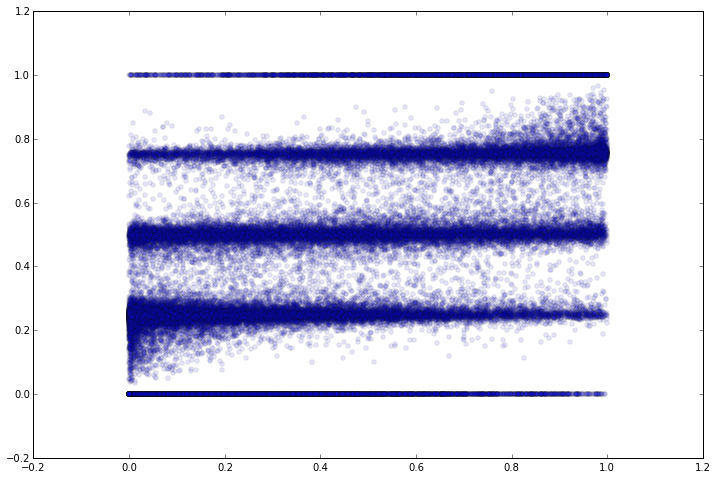

In [48]:
figsize(12, 8)

scatter(allypredxg, allypredknn4, alpha = 0.1)

Смешаем полученные модели

In [38]:
gr = np.arange(0.0, 1.01, 0.01)

res = []
for g in gr:
    res.append(multiclass_log_loss(ytrain, g * allypredxg + (1. - g) * allypredknn4))

0.447188583685 0.87


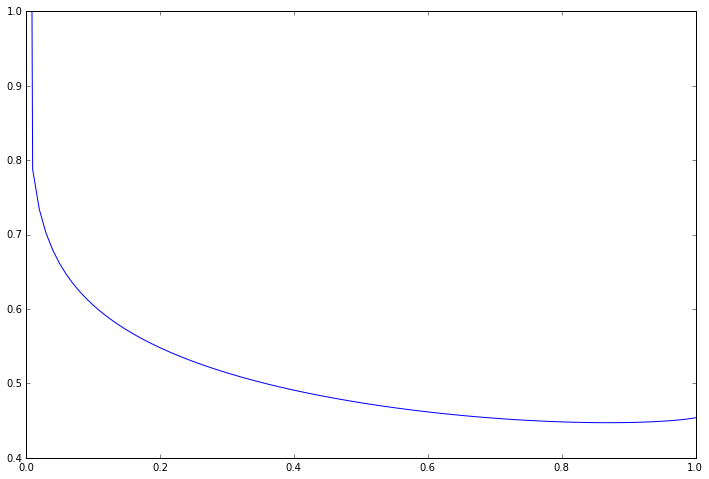

In [50]:
figsize(12, 8)
ylim(0.4, 1.0)

plot(gr, res)

print np.min(res), gr[list(res).index(min(res))]

In [51]:
N_NEIGHBORS = 16

In [52]:
t0 = time.time()

arres = []
arrlos = []
allypred = np.zeros((len(ytrain), 9))
for giba in range(5):
    indtrain1 = gibaindtrain1[giba]
    indtrain2 = gibaindtrain2[giba]

    curres, losses, ypred = stasknn(indtrain1, indtrain2)

    arres.append(curres)
    arrlos.append(losses)    
    allypred[indtrain2, :] = ypred
    
    print
    print curres, (time.time() - t0) / 60.
    print
    
print np.mean(arres, axis = 0)

print ''

for i in range(9):
    print i, np.mean(arrlos, axis = 0)[i]    


1.11925963278 1.69050986369


1.14473301684 3.4657807827


1.09598211929 5.20289618174


1.09173227786 6.96169433196


1.1730163765 8.71950904926

1.12494468465

0 0.100676195558
1 0.129293675849
2 0.177053247304
3 0.197304482088
4 0.0115664044053
5 0.138796304888
6 0.171684614777
7 0.119771301412
8 0.078798458373


In [53]:
allypredknn16 = np.array(allypred)

Построим график алгоритм-алгоритм

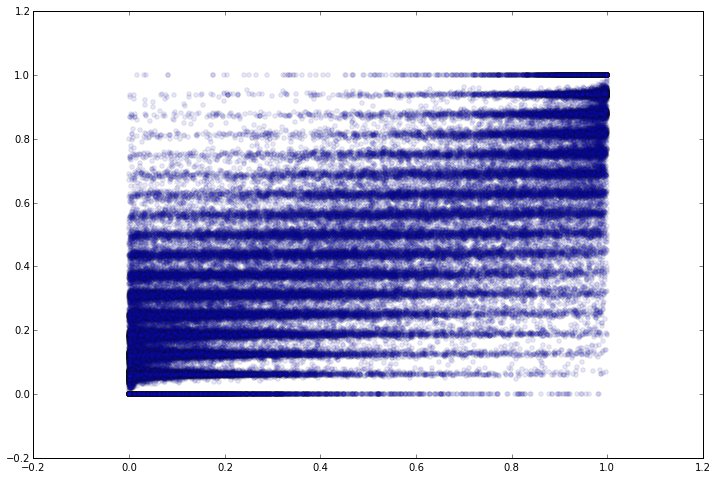

In [56]:
figsize(12, 8)

scatter(allypredxg, allypredknn16, alpha = 0.1)

In [57]:
gr = np.arange(0.0, 1.01, 0.01)

res = []
for g in gr:
    res.append(multiclass_log_loss(ytrain, g * allypredxg + (1. - g) * allypredknn16))

0.449664697051 0.89


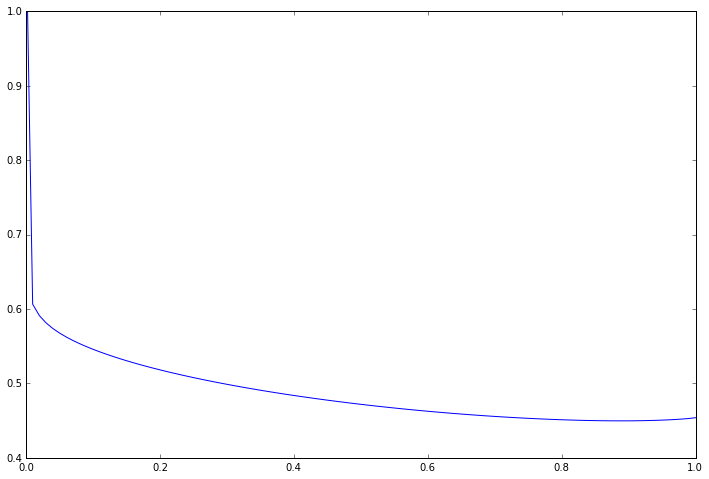

In [58]:
figsize(12, 8)
ylim(0.4, 1.0)

plot(gr, res)

print np.min(res), gr[list(res).index(min(res))]

Подгрузим данные с T-sne

In [70]:
dtsne = pd.read_csv('/home/ubuntu/OTTO_MODELS/train_tsne.csv', header = None)

In [72]:
Xtsne = np.array(dtsne.ix[:, :3])

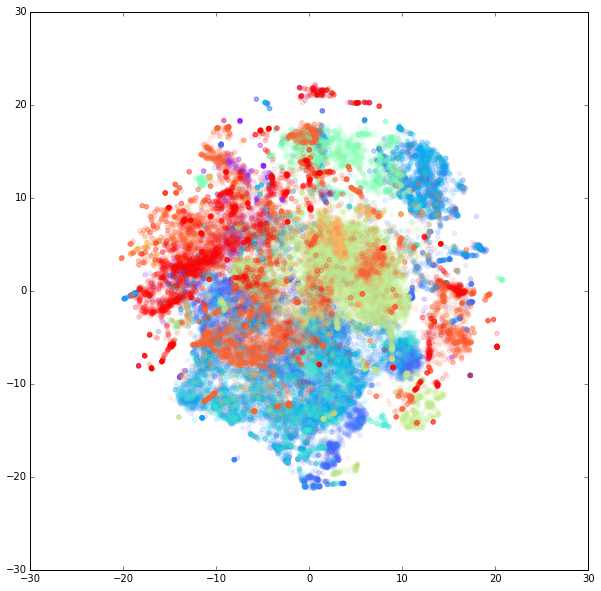

In [86]:
colors = cm.rainbow(np.linspace(0, 1, 9))

figsize(10, 10)
scatter(Xtsne[:, 0], Xtsne[:, 1], color = colors[ytrain], alpha = 0.1)

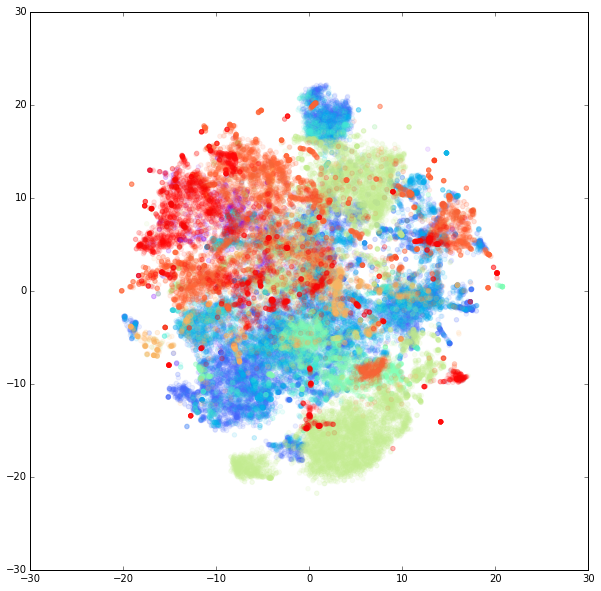

In [87]:
colors = cm.rainbow(np.linspace(0, 1, 9))

figsize(10, 10)
scatter(Xtsne[:, 0], Xtsne[:, 2], color = colors[ytrain], alpha = 0.1)